In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import pandas as pd
import os
import re
import io
import requests
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [3]:
# torch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
from sklearn.metrics import roc_auc_score
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torch import nn

In [4]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from astropy.cosmology import WMAP5
from astropy import units as u

#from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from torchmetrics.functional import auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [5]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [7]:
df = pd.read_csv('rcsed.csv')

In [8]:
gasmet = pd.read_csv('rcsed_gasmet.csv')

In [18]:
id_col = ['objid','specobjid']
z_col = [  'exp_tau','exp_met','z', 'e_bv', 'ssp_age', 'ssp_met', 'specclass']

band_col = [
    'corrmag_fuv', 'corrmag_nuv', 'corrmag_u', 'corrmag_g', 'corrmag_r', 'corrmag_i', 
    'corrmag_z', 'corrmag_y', 'corrmag_j', 'corrmag_h', 'corrmag_k'
]

kcorr_col = [
     'kcorr_fuv','kcorr_nuv','kcorr_u','kcorr_g','kcorr_r','kcorr_i',
     'kcorr_z','kcorr_y','kcorr_j','kcorr_h','kcorr_k',
]

In [19]:
col = id_col + z_col + band_col + kcorr_col

In [20]:
data = df[col].dropna()

In [21]:
import astropy

In [22]:
DL = astropy.cosmology.Planck18.luminosity_distance(data['z']).values
DL = DL.value

In [23]:
# k correlation 
DL = astropy.cosmology.Planck18.luminosity_distance(data['z']).values
DL = DL.value
kcorrmag = []
for i,j in zip(band_col, kcorr_col):
    data['kcorr'+i] = data[i].values - 5 * np.log10(DL) - 25 - data[j].values
    kcorrmag.append('kcorr'+i)

In [24]:
data[kcorrmag].head()

,kcorrcorrmag_fuv,kcorrcorrmag_nuv,kcorrcorrmag_u,kcorrcorrmag_g,kcorrcorrmag_r,kcorrcorrmag_i,kcorrcorrmag_z,kcorrcorrmag_y,kcorrcorrmag_j,kcorrcorrmag_h,kcorrcorrmag_k
18,-17.336856,-16.871063,-18.472444,-19.732151,-20.274291,-20.648209,-20.965027,-21.583594,-21.552286,-22.025731,-21.749908
20,-17.481505,-18.111204,-19.029711,-20.241857,-20.728210,-20.981151,-21.255622,-21.534054,-21.621299,-21.744257,-21.675616
25,-17.551703,-18.633691,-20.271134,-21.741472,-22.418804,-22.789307,-23.023073,-23.549892,-23.646537,-24.021527,-23.732957
28,-17.337651,-17.868070,-19.302804,-20.443275,-20.992583,-21.295717,-21.323250,-21.906601,-22.103648,-22.388740,-22.060079
29,-18.653983,-18.982750,-19.781546,-20.747881,-21.143956,-21.393290,-21.608069,-21.956285,-21.938646,-22.424797,-22.162743


In [164]:
def train(net, criterion, optimizer, epochs, trainloader):
    losses = []
    outputs_and_labels = []

    for epoch in range(1, epochs+1):
        print(f'epoch: {epoch}, ', end='')
        running_loss = 0.0
        for counter, (img, _) in enumerate(trainloader, 1):
            optimizer.zero_grad()
            output = net(img.float())
            loss = criterion(output.float(), img.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / counter
        losses.append(avg_loss)
        print('loss:', avg_loss)
        outputs_and_labels.append((output, img))
    return outputs_and_labels, losses

In [165]:
x_train = np.array( data[band_col] )

In [166]:
y_train = np.zeros([x_train.shape[0]])

In [118]:
# ミニバッチのサイズ指定
batch_size = 256

train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
trainloader = DataLoader(train_data, batch_size = batch_size, shuffle=True)

In [119]:
encoder = torch.nn.Sequential(
    nn.Linear(11,1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512,2),
)

decoder = torch.nn.Sequential(
    nn.Linear(2,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512,1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,11),
)

class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [120]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [121]:
net = AutoEncoder(encoder,decoder)
print(net)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
EPOCHS = 50

outputs_and_labels, losses = train(net, criterion, optimizer, EPOCHS, trainloader)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=11, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [126]:
latent = net.encoder(torch.from_numpy(x_train).float()).detach().numpy()

In [129]:
latent1 = latent[:,0]
latent2 = latent[:,1]

In [130]:
exp_tau = data['exp_tau'].values
exp_met = data['exp_met'].values
e_bv = data['e'].values
inputs = data[band_col]
inputs = np.array(inputs)

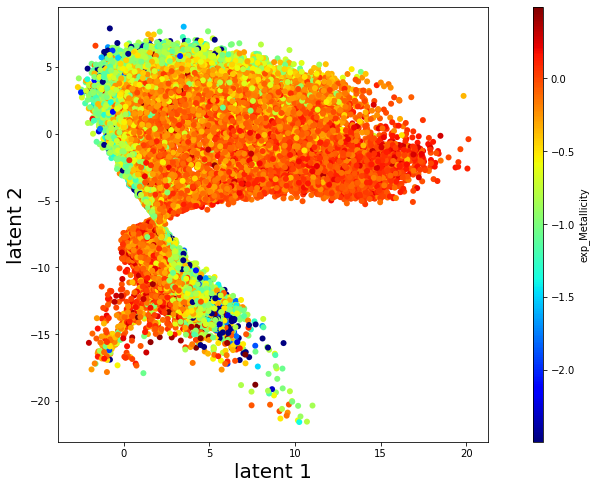

In [169]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = exp_met, cmap=plt.cm.jet, edgecolor='none',)
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'exp_Metallicity')
plt.savefig('encoder_met.png')
plt.xlabel('latent 1', fontsize = 20)
plt.ylabel('latent 2', fontsize = 20)
plt.show()

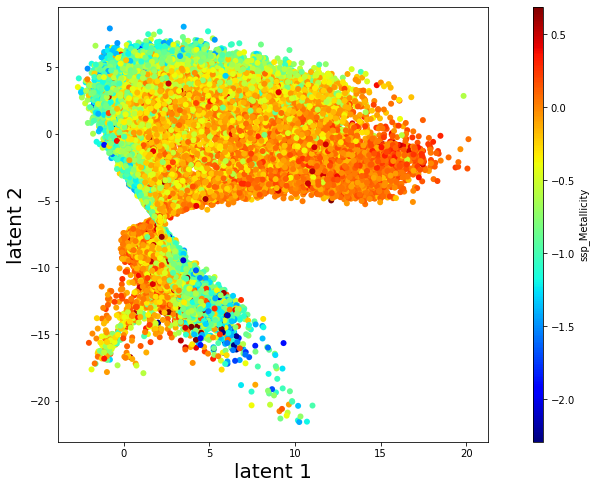

In [170]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['ssp_met'], cmap=plt.cm.jet, edgecolor='none',)
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'ssp_Metallicity')
plt.savefig('encoder_ssp_met.png')
plt.xlabel('latent 1', fontsize = 20)
plt.ylabel('latent 2', fontsize = 20)
plt.show()

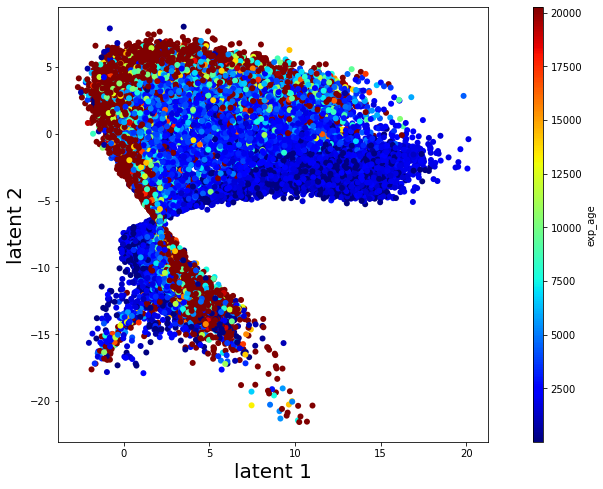

In [171]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = exp_tau, cmap=plt.cm.jet, edgecolor='none')
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'exp_age')
plt.savefig('encoder_age.png')
plt.xlabel('latent 1', fontsize = 20)
plt.ylabel('latent 2', fontsize = 20)
plt.show()

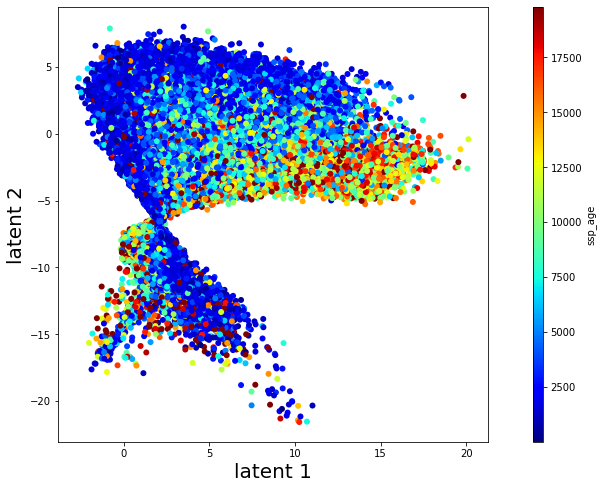

In [172]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['ssp_age'], cmap=plt.cm.jet, edgecolor='none')
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'ssp_age')
plt.savefig('encoder_age.png')
plt.xlabel('latent 1', fontsize = 20)
plt.ylabel('latent 2', fontsize = 20)
plt.show()

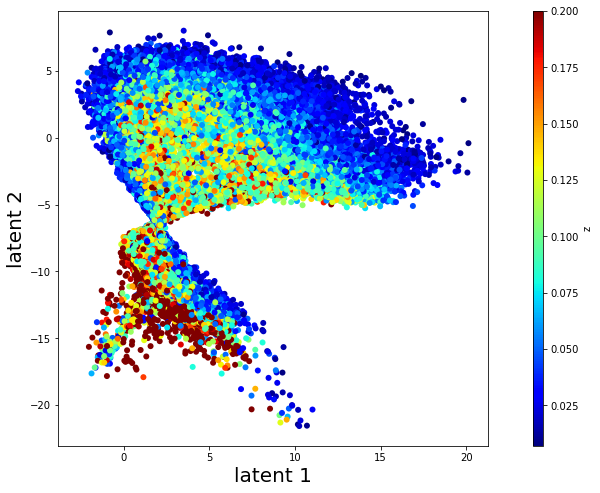

In [173]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['z'].values, cmap=plt.cm.jet, edgecolor='none', vmax=0.2)
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'z')
plt.savefig('encoder_z.png')
plt.xlabel('latent 1', fontsize = 20)
plt.ylabel('latent 2', fontsize = 20)
plt.show()

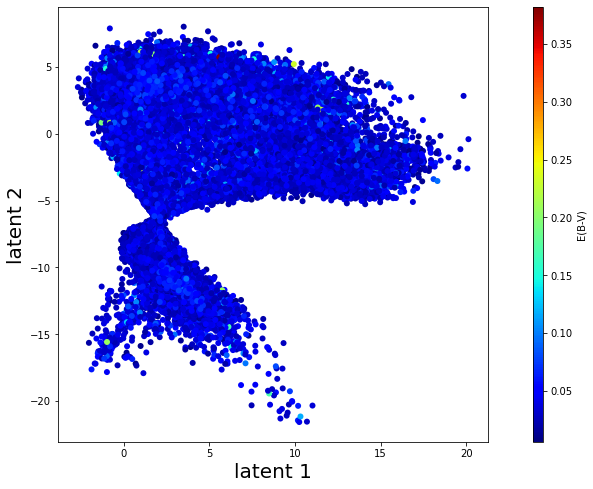

In [174]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['e_bv'].values, cmap=plt.cm.jet, edgecolor='none')
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'E(B-V)')
plt.savefig('E(B-V).png')
plt.xlabel('latent 1', fontsize = 20)
plt.ylabel('latent 2', fontsize = 20)
plt.show()

In [185]:
data['specclass'].value_counts()

2    90635
Name: specclass, dtype: int64